In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

# Load Dataset

In [2]:
data = pd.read_csv('./data/Fraud/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
address2country = pd.read_csv('./data/Fraud/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


# Add Country to Fraud Data

In [5]:
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = address2country[(address2country['lower_bound_ip_address'] <= ip_address) &
                          (address2country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
data['country'] = countries

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# Feature Engineering

* Time difference between sign-up time and purchase time
* If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
* Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
* Usual week of the year and day of the week from time variables

In [6]:
# Get the time difference between purchase time and signup time
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [7]:
# Check user number for unique devices
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')

In [8]:
# Check user number for unique ip_address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [9]:
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [10]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [11]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


# Fraudulent Activity Identification

In [12]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gx/b15jqbt1567grsfr7l_znn2h0000gn/T/tmpq14c42t4
  JVM stdout: /var/folders/gx/b15jqbt1567grsfr7l_znn2h0000gn/T/tmpq14c42t4/h2o_jifu_started_from_python.out
  JVM stderr: /var/folders/gx/b15jqbt1567grsfr7l_znn2h0000gn/T/tmpq14c42t4/h2o_jifu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,3 months
H2O cluster name:,H2O_from_python_jifu_3z98p9
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [13]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
type,enum,int,enum,int,int,enum,enum,enum,int,enum,int,int,int,enum
mins,,1.0,,1.0,9.0,,,,18.0,,1.0,1.0,1.0,
mean,,16.501740430938508,,24.658571126052173,36.93537243898567,,,,33.14070358409671,,40942.584427444956,1.6843665625496433,1.6027185134205137,
maxs,,34.0,,51.0,154.0,,,,76.0,,86399.0,20.0,20.0,
sigma,,9.814287461798854,,11.651556782719474,18.32276214866212,,,,8.617733490961495,,26049.661902118358,2.6169536028041693,2.596239527375835,
zeros,,0,,0,0,,,,0,,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,9.0,5,16.0,34.0,SEO,Chrome,M,39.0,Japan,13882.0,1.0,1.0,0
1,6,23.0,0,24.0,16.0,Ads,Chrome,F,53.0,United States,17944.0,1.0,1.0,0
2,3,1.0,3,1.0,15.0,SEO,Opera,M,53.0,United States,1.0,12.0,12.0,1


In [14]:
# Split into 70% training and 30% test dataset
strat_split = h2o_df['class'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

# Define features and target
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num']
target = 'class'

In [15]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [16]:
model.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
0,,2018-05-20 20:25:44,0.100 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2018-05-20 20:25:45,1.181 sec,1.0,0.329237,0.763404,0.956487,1.930543,0.103585,0.257295,1.705777,0.780964,7.318324,0.064986
2,,2018-05-20 20:25:46,1.837 sec,2.0,0.337703,0.666988,0.958739,1.945962,0.100437,0.211104,0.612876,0.808146,10.238311,0.045618
3,,2018-05-20 20:25:47,2.924 sec,3.0,0.342474,0.585470,0.962420,1.959389,0.096241,0.205624,0.416203,0.820663,10.566838,0.044361
4,,2018-05-20 20:25:48,4.475 sec,4.0,0.341220,0.530667,0.967584,1.967190,0.088710,0.204276,0.340733,0.823580,10.641350,0.044140
5,,2018-05-20 20:25:49,4.799 sec,5.0,0.339991,0.494876,0.970585,1.973005,0.085154,0.203786,0.294007,0.825970,10.669638,0.044162
6,,2018-05-20 20:25:49,5.173 sec,6.0,0.338576,0.454248,0.974636,1.979192,0.081914,0.203566,0.268536,0.828691,10.674389,0.044096
7,,2018-05-20 20:25:49,5.534 sec,7.0,0.337354,0.427348,0.977835,1.983172,0.076219,0.203257,0.251817,0.830573,10.679152,0.044096
8,,2018-05-20 20:25:50,5.923 sec,8.0,0.337933,0.405616,0.980248,1.987241,0.072625,0.203124,0.243703,0.831204,10.679152,0.044118
9,,2018-05-20 20:25:50,6.339 sec,9.0,0.336345,0.385657,0.982926,1.990128,0.067415,0.203066,0.231357,0.832550,10.679152,0.044118


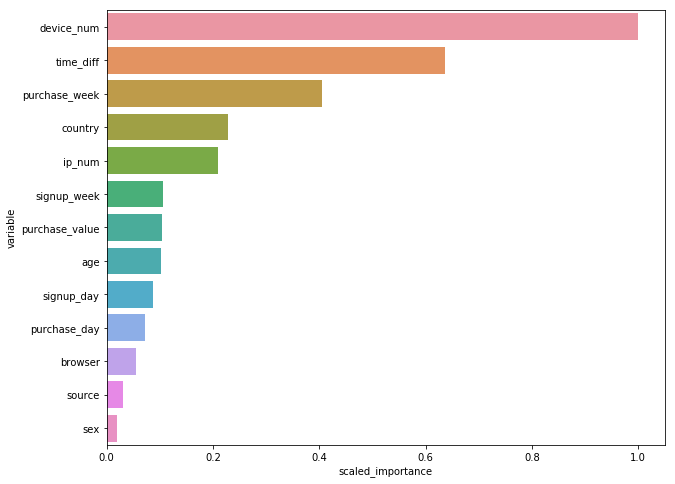

In [17]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [18]:
# Make predictions 
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [19]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     41088
          1       1.00      0.53      0.69      4245

avg / total       0.96      0.96      0.95     45333



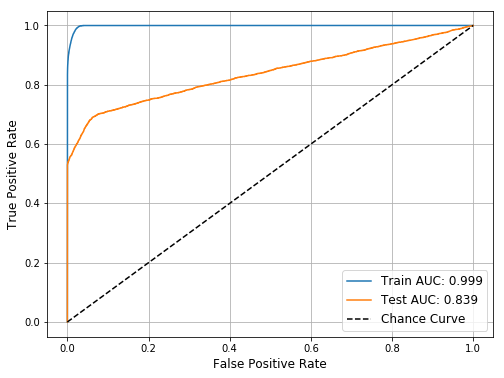

In [20]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


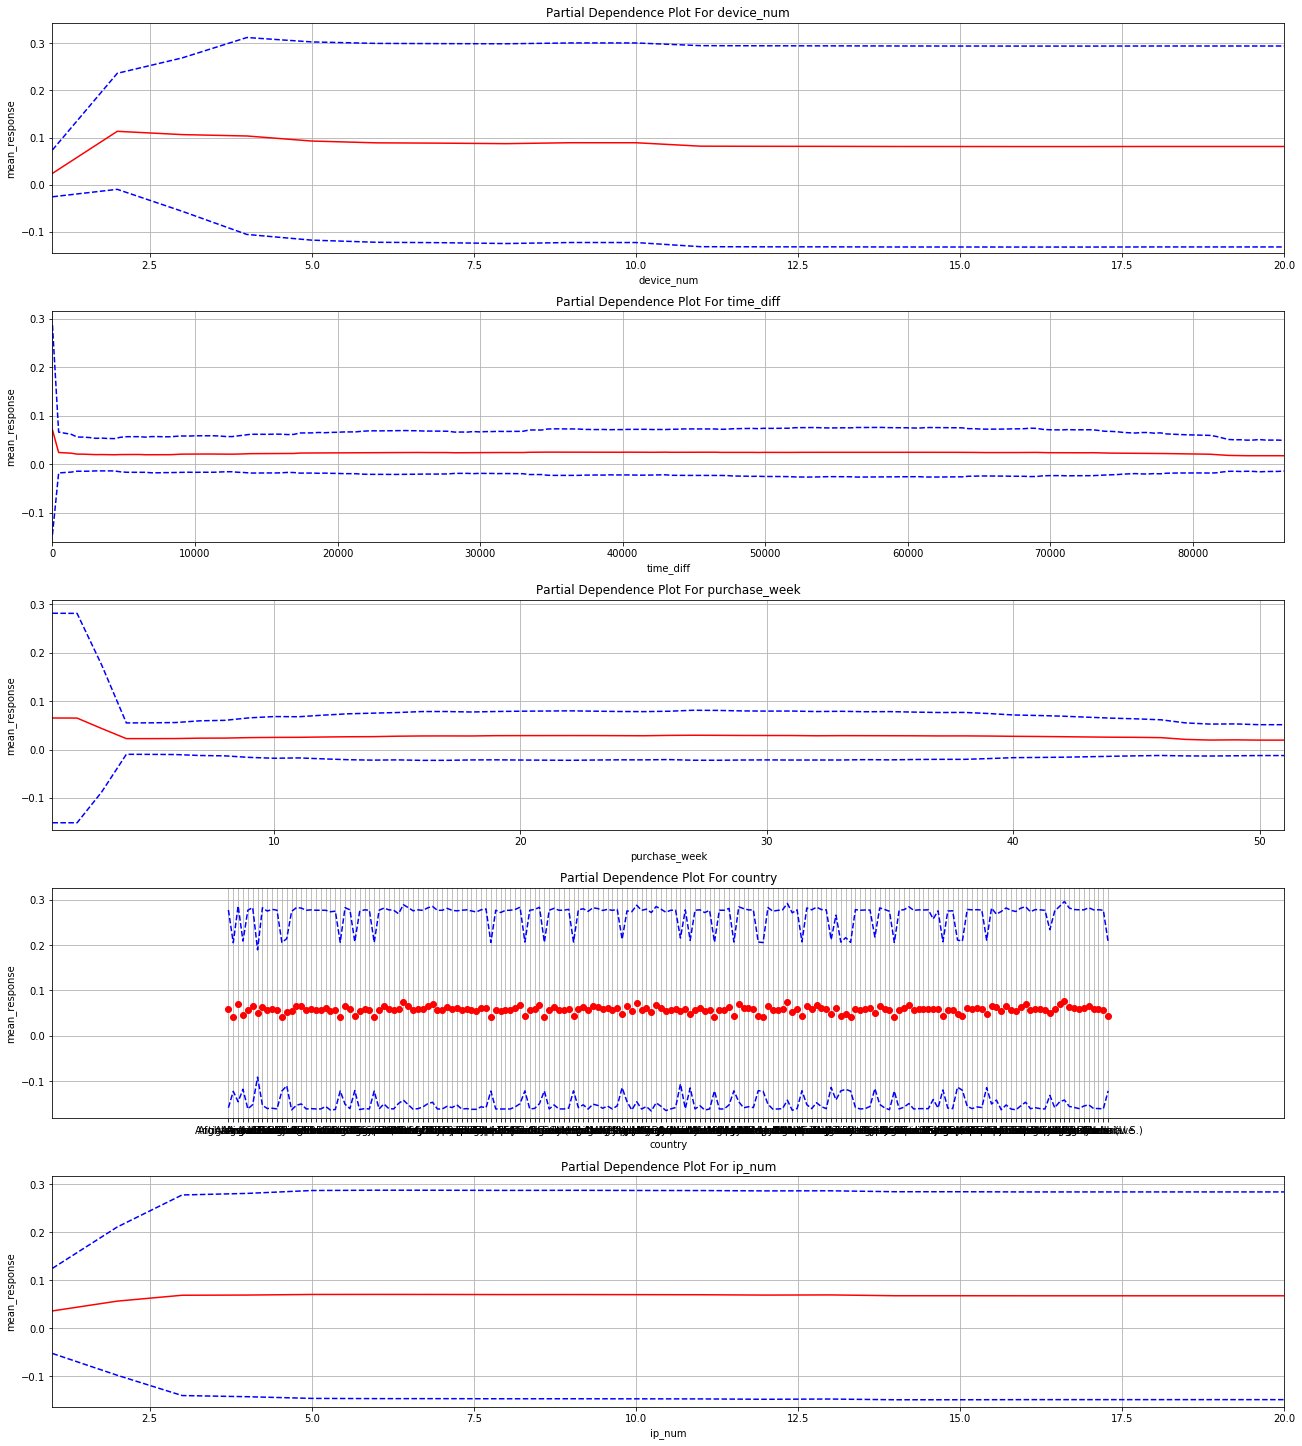

In [22]:
cols = ['device_num', 'time_diff', 'purchase_week', 'country', 'ip_num']
_ = model.partial_plot(data=train, cols=cols, nbins=200, figsize=(18, 20))

In [23]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_a179 closed.


Regarding “how to use this from a product perspective”: you now have a model that assigns to each user a probability of committing a fraud. You want to think about creating different experiences based on that. For instance:

1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.

This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives).